<a href="https://colab.research.google.com/github/setthawut8/ai/blob/main/eda/%5Bcomputer_vision%5D_wandb_%26_plotCategories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#connect kaggle

In [5]:
%%capture

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c hubmap-organ-segmentation #download data from the Kaggle competition"

In [ ]:
%%capture
!unzip '/content/hubmap-organ-segmentation.zip'

#install weight and bias library
!pip install wandb

#data processing

In [6]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tifffile as tiff 
from tqdm.auto import tqdm

plt.style.use("Solarize_Light2")

# Wandb Login
import wandb
wandb.login()


from wandb.keras import WandbCallback

wandb: Currently logged in as: setthawut-kul (superai2-optimizer). Use `wandb login --relogin` to force relogin


#data
https://www.kaggle.com/code/ishandutta/hubmap-complete-understanding-and-eda-w-b

In [10]:
class config:
  BASE_PATH = '/content/'
  TRAIN_PATH = BASE_PATH + 'tran_images'

# wandb config
WANDB_CONFIG = {
     'competition': 'HuBMAP', 
     '_wandb_kernel': 'neuracort'
    }

# Initialize W&B
run = wandb.init(
    project='hubmap-organ-segmentation', 
    config= WANDB_CONFIG
)

In [ ]:
#see df
df = pd.read_csv(config.BASE_PATH+'train.csv')

#log data in wandb
wandb.log({"df_train": df})

df.head()

##actual image

In [12]:
img_id_1 = 10044
img_1 = tiff.imread(config.BASE_PATH + 'train_images/' + str(img_id_1) + '.tiff')

print(img_1.shape)

(3000, 3000, 3)


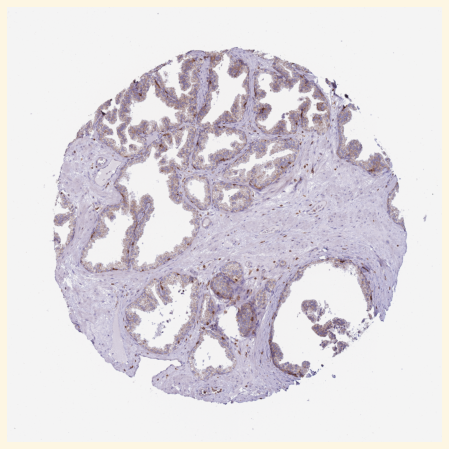

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(img_1)
plt.axis('off')

wandb.log({"Image Sample 1": plt})

##mask

In [14]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [15]:
mask_1 = rle2mask(df[df["id"]==img_id_1]["rle"].iloc[-1], (img_1.shape[1], img_1.shape[0]))
mask_1.shape

(3000, 3000)

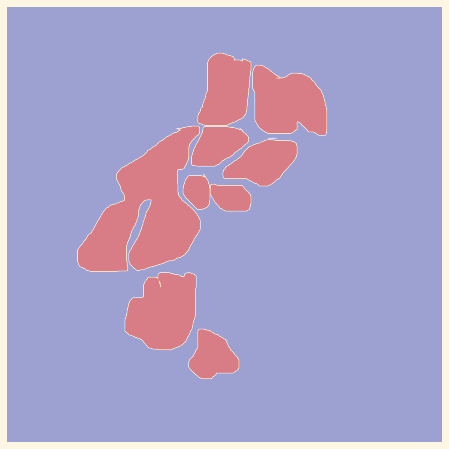

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")
wandb.log({"Mask Sample 1": plt})

##combine image with mask

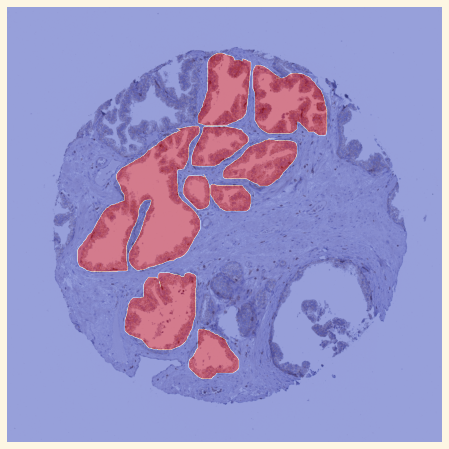

In [19]:
plt.figure(figsize=(8, 8))
plt.imshow(img_1)
plt.imshow(mask_1, cmap='coolwarm', alpha=0.5)
plt.axis("off")
wandb.log({"Image with Mask Sample 1": plt})

##interactive between images and masks

In [20]:
image_ids = df.id
image_files = glob.glob(config.BASE_PATH + "/train_images/*")

In [ ]:
def save_table(table_name):
    table = wandb.Table(columns=['Id', 'Image', 'Mask', 'Image with Mask'], allow_mixed_types = True)

    for id, img in tqdm(zip(image_ids, image_files), total = len(image_ids)):

        img = tiff.imread(img)
        mask = rle2mask(df[df["id"]==id]["rle"].iloc[-1], (img.shape[1], img.shape[0]))
        
        plt.figure(figsize=(10,10))
        plt.axis("off")
        plt.imshow(img)
        plt.imshow(mask, cmap='coolwarm', alpha=0.5)
        plt.savefig("./image.jpg")
        plt.close()

        table.add_data(
            id, 
            wandb.Image(img), 
            wandb.Image(mask),
            wandb.Image(cv2.cvtColor(cv2.imread("./image.jpg"), cv2.COLOR_BGR2RGB))
        )

    wandb.log({table_name : table})
     
save_table("Images and Masks Record")

  0%|          | 0/351 [00:00<?, ?it/s]

##all orgran types

Text(0.5, 1.0, 'Data Source')

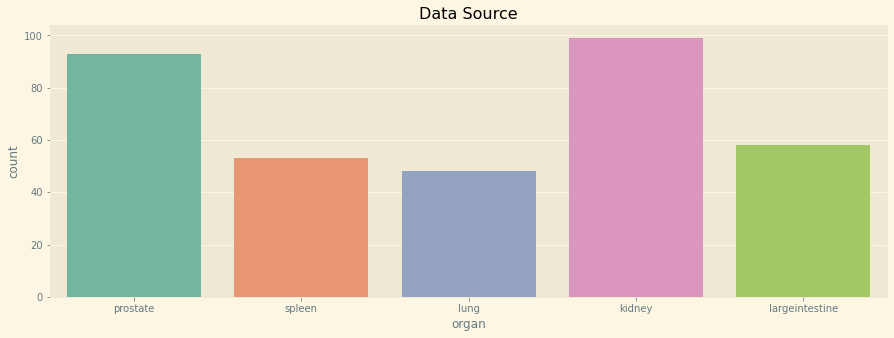

In [38]:
plt.figure(figsize=(15, 5))
g = sns.countplot(data=df, x="organ", palette=sns.color_palette("Set2", 8))
g.set_title("Data Source", color = "black")

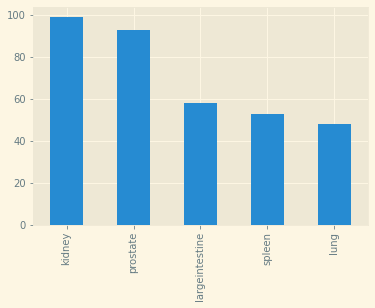

In [43]:
df.organ.value_counts().sort_values(ascending=False).plot.bar()

##all data types

Text(0.5, 1.0, 'Data Source')

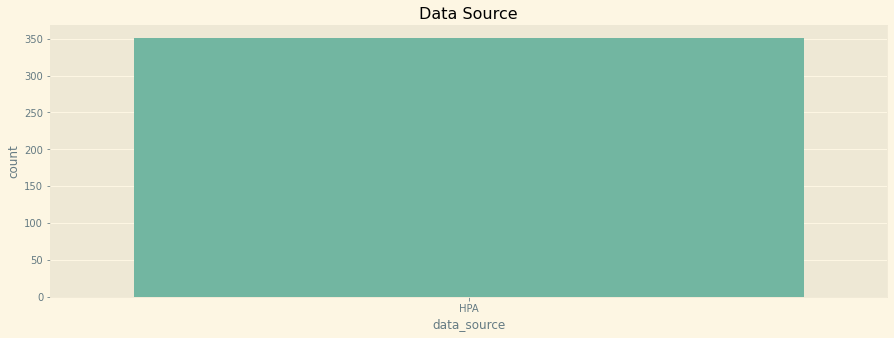

In [22]:
plt.figure(figsize=(15, 5))
g = sns.countplot(data=df, x="data_source", palette=sns.color_palette("Set2", 8))
g.set_title("Data Source", color = "black")

##all age types

Text(0.5, 1.0, 'Age')

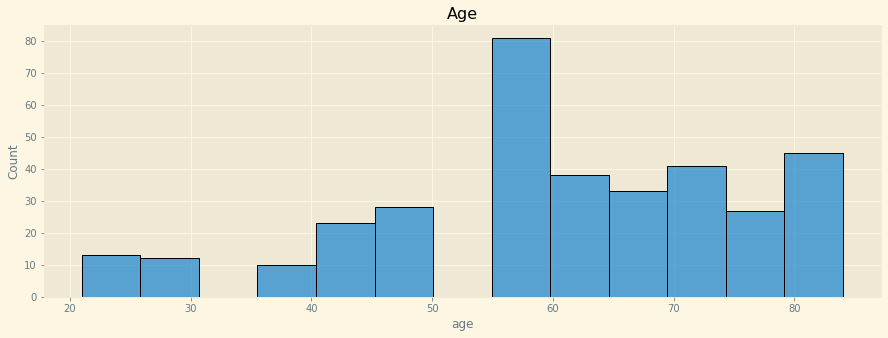

In [23]:
plt.figure(figsize=(15, 5))
g = sns.histplot(data=df, x="age", palette=sns.color_palette("Set2", 8))
g.set_title("Age", color = "black")

##all sex types

Text(0.5, 1.0, 'Sex')

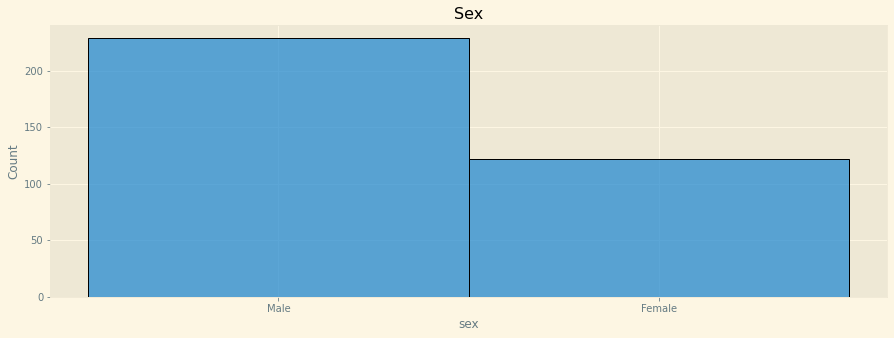

In [24]:
plt.figure(figsize=(15, 5))
g = sns.histplot(data=df, x="sex", palette=sns.color_palette("Set2", 8))
g.set_title("Sex", color = "black")

#model: resnet152
https://www.kaggle.com/code/thedevastator/inference-fastai-baseline

#kaggle submit

In [ ]:
#kaggle competitions download -c mayo-clinic-strip-ai
# !kaggle competitions submit -c super-ai-engineer-2021-mi-eeg-classification -f ready_submission.csv -m "Submit from Colab"